In [1]:
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import f1_score, precision_score, recall_score, \
    accuracy_score

import re
from typing import List, Tuple

import pandas as pd


def is_contained(inner_start, inner_end, outer_start, outer_end):
    return (
        outer_start <= inner_start <= outer_end
        and outer_start <= inner_end <= outer_end
        and (inner_start, inner_end) != (outer_start, outer_end)
    )


def find_all_occurrences_indices(
    sentence: str,
    label: str,
) -> List[Tuple[int, int]]:
    """
    Finds all occurrences of a label in a sentence and returns a list of tuples
    with the start and end indices of the occurrences.

    Args:
        sentence: The sentence to search in.
        label: The label to search for.

    Returns:
        A list of tuples with the start and end indices of the occurrences.
    """
    return [
        (int(match.start()), int(match.end()))
        for match in re.finditer(label, sentence)
    ]


def find_contained_labels(labels):
    """
    Finds all labels that are contained in other labels.

    Args:
        labels: A list of labels.

    Returns:
        A dictionary with the labels as keys and a list of labels that are
        contained in the key label as values.
    """
    return {
        label_1: [
            label2
            for label2 in labels
            if label_1 in label2 and label_1 != label2
        ]
        for label_1 in labels
    }


def find_labels_in_sentence(
    sentence: str,
    labels: List[str],
) -> List[List[Tuple[int, int]]]:
    """
    Finds all occurrences of the labels in a sentence and returns a list of
    lists with the occurrences of each label.

    Labels that are contained in other labels are not returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.

    Returns:
        A list of lists with the positional occurrence of each label.
    """
    if not labels:
        return []

    containable_map = find_contained_labels(labels)
    sentence_lower = sentence.lower()
    occurrences = [
        find_all_occurrences_indices(sentence_lower, label.lower())
        for label in labels
    ]
    label_occurrences = dict(zip(labels, occurrences))
    included_list = []
    for label, inner_pos in zip(labels, occurrences):
        contained = set()
        containing_labels = containable_map.get(label, set())

        for bigger_label in containing_labels:
            locations: List[Tuple[int, int]] = label_occurrences.get(
                bigger_label,
                list(),
            )

            for inner_start, inner_end in inner_pos:
                for outer_start, outer_end in locations:
                    if is_contained(
                        inner_start,
                        inner_end,
                        outer_start,
                        outer_end,
                    ):
                        contained.add((inner_start, inner_end))
        included_list.append(list(contained))

    return [
        list(set(pos) - set(included))
        for pos, included in zip(occurrences, included_list)
    ]


def find_label(
    sentence: str,
    labels: List[str],
    default_label: str = "?",
) -> str:
    """
    Search for given labels in the sentence and returns it if found. If only
    one label occur in the sentence, it will be returned. If no label or
    different labels occur in the sentence, '?' is returned.

    Args:
        sentence: The sentence to search in.
        labels: The labels to search for.
        default_label: The label to return if no label or different labels
            occur in the sentence.

    Returns:
        The label that occurs in the sentence or '?' if no label occurs in the
        sentence.
    """
    occurrences = find_labels_in_sentence(sentence=sentence, labels=labels)
    non_empty_indices = [i for i, sublist in enumerate(occurrences) if sublist]
    return (
        labels[non_empty_indices[0]]
        if len(
            non_empty_indices,
        )
           == 1
        else default_label
    )


def _soft_parse(
    df: pd.DataFrame,
    in_col: str,
    parsed_col: str,
    labels: List[str] = None,
) -> pd.DataFrame:
    if labels is None:
        raise ValueError("Labels are not set!")

    df[parsed_col] = df[in_col].apply(
        lambda x: find_label(x, labels),
    )


In [2]:

# load

# load results
df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
df_flan_t5_base = pd.read_csv("./data/flan-t5-base.csv")
df_flan_t5_large = pd.read_csv("./data/flan-t5-large.csv")
df_flan_t5_xl = pd.read_csv("./data/flan-t5-xl.csv")
df_openai_gpt_3_5_turbo = pd.read_csv('./data/gpt-3.5-turbo.csv')
df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4.csv")
df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")

#load pool
pool = load_dataset('mediabiasgroup/BABE-icl-pool')['train'].to_pandas()

# exclude pool from model (if needed)
df_falcon_7b = df_falcon_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_flan_ul2 = df_flan_ul2.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.merge(pool['text'], on='text', how='left',
                              indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_7b = df_Llama_2_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_Llama_2_13b = df_Llama_2_13b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mistral_7b = df_mistral_7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_mixtral_8x7b = df_mixtral_8x7b.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_openchat_3_5 = df_openchat_3_5.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)
df_zephyr_7b_beta = df_zephyr_7b_beta.merge(pool['text'], on='text', how='left',
                            indicator=True).query(
    '_merge == "left_only"').drop('_merge', axis=1)



#load babe
dataset = load_dataset('mediabiasgroup/BABE-v4')
df_babe = pd.DataFrame(dataset['train'])

# df_merge_all_runs = only contains the elements legal in all annotations
df_merge_all_runs = df_babe

# df_merge_all_runs_with_errors = only contains the elements legal in all annotations
df_merge_all_runs_with_errors = df_babe


def find_first_occurrence(string, instruction="Instruction:",
                          statement1="The answer is BIASED",
                          statement2="The answer is NOT BIASED"
                          ):
    index_instruction = string.find(instruction)
    index1 = string.find(statement1)
    index2 = string.find(statement2)

    if index1 == -1 and index2 == -1:
        return "Neither instruction nor statements found in the given string."
    elif index1 == -1 and index2 == -1:
        return "Neither statement found in the given string."
    elif index1 == -1:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"
    elif index2 == -1:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    elif index1 < index2:
        if index_instruction == -1 or index1 < index_instruction:
            return f"{statement1}"
        else:
            return "After Instruction"
    else:
        if index_instruction == -1 or index2 < index_instruction:
            return f"{statement2}"
        else:
            return "After Instruction"

# Falcon 7B

In [3]:
_soft_parse(df_falcon_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
20,A Joe Biden presidency could reset ties with t...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
95,The head of the World Health Organization said...,'NOT BIASED'\n\nExplanation: The sentence does...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
196,With radical feminists and extremist trans act...,'NOT BIASED'\n\nExplanation: The sentence port...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
297,This is why Donald Trump is awake at 2:30 a.m....,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
383,While the stupid Democrats who vote for Democr...,'NOT BIASED'\n\nExplanation: The sentence cont...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
3658,acked by Virginia’s first Democratic-controlle...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3837,It amazes me that even intelligent people – in...,'NOT BIASED'\n\nExplanation: The sentence is n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3845,The movement’s hysteric leader proceeded to hu...,"'Hysteric' (BIASED), 'leader' (NOT BIASED),'mo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3851,A leading economist who vouched for Democratic...,'NOT BIASED'\n\nExplanation: The sentence pres...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [4]:
# preprocessing
def update_label(row):
    if row['response'].startswith("'BIASED'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'Biased'") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("1") and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith("'NOT BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not BIASED'") and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith("'Not Biased'") and row[
        'label'] == '?':
        return 'NOT BIASED'

    else:
        return row['label']


df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
2062,'Pandemic Apprentice': Deprived of rallies to ...,'Pandemic Apprentice': Deprived of rallies to ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3845,The movement’s hysteric leader proceeded to hu...,"'Hysteric' (BIASED), 'leader' (NOT BIASED),'mo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [5]:
# preprocessing

df_falcon_7b['label'] = df_falcon_7b.apply(update_label, axis=1)
df_falcon_7b.query("label == '?'")

,text,response,raw_data,query,label
2062,'Pandemic Apprentice': Deprived of rallies to ...,'Pandemic Apprentice': Deprived of rallies to ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3845,The movement’s hysteric leader proceeded to hu...,"'Hysteric' (BIASED), 'leader' (NOT BIASED),'mo...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [6]:
df_falcon_7b = df_falcon_7b.rename(columns={"label": "falcon_7b_label"})
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('BIASED', 1)
df_falcon_7b['falcon_7b_label'] = df_falcon_7b['falcon_7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_falcon_7b[df_falcon_7b['falcon_7b_label'] != '?'][['text', 'falcon_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_falcon_7b[['text', 'falcon_7b_label']], on='text')

ground_truth = df_merge['label'].astype(int)
falcon_7b_label = df_merge['falcon_7b_label'].astype(int)

In [7]:
print("F1-Score with Falcon 7b with (0 shot + Sys. Prompt): ",
      f1_score(ground_truth, falcon_7b_label))
print("Precision with Falcon 7b with (0 shot + Sys. Prompt): ",
      precision_score(ground_truth, falcon_7b_label))
print("Recall with Falcon 7b with (0 shot + Sys. Prompt): ",
      recall_score(ground_truth, falcon_7b_label))
print("Accuracy with Falcon 7b with (0 shot + Sys. Prompt): ",
      accuracy_score(ground_truth, falcon_7b_label))

F1-Score with Falcon 7b with (0 shot + Sys. Prompt):  0.5074925074925075
Precision with Falcon 7b with (0 shot + Sys. Prompt):  0.5042183622828784
Recall with Falcon 7b with (0 shot + Sys. Prompt):  0.5108094519859225
Accuracy with Falcon 7b with (0 shot + Sys. Prompt):  0.5093306792734511


# Flan UL2

In [8]:
_soft_parse(df_flan_ul2, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_ul2.query("label == '?'")

,text,response,raw_data,query,label


In [9]:
df_flan_ul2 = df_flan_ul2.rename(columns={"label": "flan_ul2_label"})
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('BIASED', 1)
df_flan_ul2['flan_ul2_label'] = df_flan_ul2['flan_ul2_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_ul2[df_flan_ul2['flan_ul2_label'] != '?'][['text', 'flan_ul2_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_ul2[['text', 'flan_ul2_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_ul2_label = df_merge['flan_ul2_label'].astype(int)

In [10]:
print("F1-Score with Flan UL2 (0 Shot + Sys Prompt): ", f1_score(ground_truth, flan_ul2_label))
print("Precision with Flan UL2 (0 Shot + Sys Prompt): ", precision_score(ground_truth, flan_ul2_label))
print("Recall with Flan UL2 (0 Shot + Sys Prompt): ", recall_score(ground_truth, flan_ul2_label))
print("Accuracy with Flan UL2 (0 Shot + Sys Prompt): ",  accuracy_score(ground_truth, flan_ul2_label))

F1-Score with Flan UL2 (0 Shot + Sys Prompt):  0.7203867848509267
Precision with Flan UL2 (0 Shot + Sys Prompt):  0.7742494226327945
Recall with Flan UL2 (0 Shot + Sys Prompt):  0.6735308890005023
Accuracy with Flan UL2 (0 Shot + Sys Prompt):  0.7411091768216862


# Flan T5 base

In [11]:
_soft_parse(df_flan_t5_base, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_base.query("label == '?'")

,text,response,raw_data,query,label


In [12]:
df_flan_t5_base = df_flan_t5_base.rename(columns={"label": "flan_t5_base_label"})
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('BIASED', 1)
df_flan_t5_base['flan_t5_base_label'] = df_flan_t5_base['flan_t5_base_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_base[df_flan_t5_base['flan_t5_base_label'] != '?'][['text', 'flan_t5_base_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_base[['text', 'flan_t5_base_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_base_label = df_merge['flan_t5_base_label'].astype(int)

In [13]:
print("F1-Score with Flan T5 base (0 shot): ", f1_score(ground_truth, flan_t5_base_label))
print("Precision with Flan T5 base (0 shot): ", precision_score(ground_truth, flan_t5_base_label))
print("Recall with Flan T5 base (0 shot): ", recall_score(ground_truth, flan_t5_base_label))
print("Accuracy with Flan T5 base (0 shot): ",  accuracy_score(ground_truth, flan_t5_base_label))

F1-Score with Flan T5 base (0 shot):  0.6609257265877286
Precision with Flan T5 base (0 shot):  0.5213699405604302
Recall with Flan T5 base (0 shot):  0.9024987751102401
Accuracy with Flan T5 base (0 shot):  0.5413734530453773


# Flan T5 large

In [14]:
_soft_parse(df_flan_t5_large, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_large.query("label == '?'")

,text,response,raw_data,query,label


In [15]:
df_flan_t5_large = df_flan_t5_large.rename(columns={"label": "flan_t5_large_label"})
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('BIASED', 1)
df_flan_t5_large['flan_t5_large_label'] = df_flan_t5_large['flan_t5_large_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_large[df_flan_t5_large['flan_t5_large_label'] != '?'][['text', 'flan_t5_large_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_large[['text', 'flan_t5_large_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_large_label = df_merge['flan_t5_large_label'].astype(int)

In [16]:
print("F1-Score with Flan T5 Large (0 shot + Sys Prompt): ", f1_score(ground_truth, flan_t5_large_label))
print("Precision with Flan T5 Large (0 shot + Sys Prompt): ", precision_score(ground_truth, flan_t5_large_label))
print("Recall with Flan T5 Large (0 shot + Sys Prompt): ", recall_score(ground_truth, flan_t5_large_label))
print("Accuracy with Flan T5 Large (0 shot + Sys Prompt): ",  accuracy_score(ground_truth, flan_t5_large_label))

F1-Score with Flan T5 Large (0 shot + Sys Prompt):  0.6692776327241079
Precision with Flan T5 Large (0 shot + Sys Prompt):  0.6019569471624266
Recall with Flan T5 Large (0 shot + Sys Prompt):  0.7535521803037727
Accuracy with Flan T5 Large (0 shot + Sys Prompt):  0.631157486047076


# Flan T5 Xl

In [17]:
_soft_parse(df_flan_t5_xl, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_flan_t5_xl.query("label == '?'")

,text,response,raw_data,query,label
1705,Tennessee has an annual sales tax-free holiday...,Not bias,Not bias,You are an expert in media bias.\n\nInstructio...,?


In [18]:
df_flan_t5_xl.loc[[1705], 'label'] = 'NOT BIASED'

In [19]:
df_flan_t5_xl = df_flan_t5_xl.rename(columns={"label": "flan_t5_xl_label"})
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('BIASED', 1)
df_flan_t5_xl['flan_t5_xl_label'] = df_flan_t5_xl['flan_t5_xl_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_flan_t5_xl[df_flan_t5_xl['flan_t5_xl_label'] != '?'][['text', 'flan_t5_xl_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_flan_t5_xl[['text', 'flan_t5_xl_label']], on='text')

ground_truth = df_merge['label'].astype(int)
flan_t5_xl_label = df_merge['flan_t5_xl_label'].astype(int)

In [20]:
print("F1-Score with Flan T5 xl (0 Shot + Sys Prompt): ", f1_score(ground_truth, flan_t5_xl_label))
print("Precision with Flan T5 xl (0 Shot + Sys Prompt): ", precision_score(ground_truth, flan_t5_xl_label))
print("Recall with Flan T5 xl (0 Shot + Sys Prompt): ", recall_score(ground_truth, flan_t5_xl_label))
print("Accuracy with Flan T5 xl (0 Shot + Sys Prompt): ",  accuracy_score(ground_truth, flan_t5_xl_label))

F1-Score with Flan T5 xl (0 Shot + Sys Prompt):  0.5226896323285856
Precision with Flan T5 xl (0 Shot + Sys Prompt):  0.8067484662576687
Recall with Flan T5 xl (0 Shot + Sys Prompt):  0.3865752082312592
Accuracy with Flan T5 xl (0 Shot + Sys Prompt):  0.6503275903906819


# GPT-3.5-turbo

In [21]:
_soft_parse(df_openai_gpt_3_5_turbo, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_openai_gpt_3_5_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [22]:
df_openai_gpt_3_5_turbo = df_openai_gpt_3_5_turbo.rename(columns={"label": "gpt_3_5_label"})
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'BIASED', 1)
df_openai_gpt_3_5_turbo['gpt_3_5_label'] = df_openai_gpt_3_5_turbo['gpt_3_5_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_3_5_turbo[df_openai_gpt_3_5_turbo['gpt_3_5_label'] != '?'][['text', 'gpt_3_5_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_3_5_turbo[['text', 'gpt_3_5_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_3_5_label = df_merge['gpt_3_5_label'].astype(int)

In [23]:
print("F1-Score with GPT 3.5 Turbo with (0 Shot + Sys Prompt): ",
      f1_score(ground_truth, gpt_3_5_label))
print("Precision with GPT 3.5 Turbo with (0 Shot + Sys Prompt): ",
      precision_score(ground_truth, gpt_3_5_label))
print("Recall with GPT 3.5 Turbo with (0 Shot + Sys Prompt): ",
      recall_score(ground_truth, gpt_3_5_label))
print("Accuracy with GPT 3.5 Turbo with (0 Shot + Sys Prompt): ",
      accuracy_score(ground_truth, gpt_3_5_label))

F1-Score with GPT 3.5 Turbo with (0 Shot + Sys Prompt):  0.7418086500655307
Precision with GPT 3.5 Turbo with (0 Shot + Sys Prompt):  0.7757675438596491
Recall with GPT 3.5 Turbo with (0 Shot + Sys Prompt):  0.7106981416373681
Accuracy with GPT 3.5 Turbo with (0 Shot + Sys Prompt):  0.7550360606814225


# GPT 4 - turbo

In [24]:
_soft_parse(df_openai_gpt_4_turbo, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_openai_gpt_4_turbo.query("label == '?'")

,text,response,raw_data,query,label


In [25]:
df_openai_gpt_4_turbo = df_openai_gpt_4_turbo.rename(columns={"label": "gpt_4_label"})
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'BIASED', 1)
df_openai_gpt_4_turbo['gpt_4_label'] = df_openai_gpt_4_turbo['gpt_4_label'].replace(
    'NOT BIASED',
    0)

df_merge = df_babe.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openai_gpt_4_turbo[df_openai_gpt_4_turbo['gpt_4_label'] != '?'][['text', 'gpt_4_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openai_gpt_4_turbo[['text', 'gpt_4_label']], on='text')


ground_truth = df_merge['label'].astype(int)
gpt_4_label = df_merge['gpt_4_label'].astype(int)

In [26]:
print("F1-Score with GPT 4 turbo with (0 Shot + Sys Prompt): ",
      f1_score(ground_truth, gpt_4_label))
print("Precision with GPT 4 turbo with (0 Shot + Sys Prompt): ",
      precision_score(ground_truth, gpt_4_label))
print("Recall with GPT 4 turbo with (0 Shot + Sys Prompt): ",
      recall_score(ground_truth, gpt_4_label))
print("Accuracy with GPT 4 turbo with (0 Shot + Sys Prompt): ",
      accuracy_score(ground_truth, gpt_4_label))

F1-Score with GPT 4 turbo with (0 Shot + Sys Prompt):  0.780759493670886
Precision with GPT 4 turbo with (0 Shot + Sys Prompt):  0.7871362940275651
Recall with GPT 4 turbo with (0 Shot + Sys Prompt):  0.7744851833249623
Accuracy with GPT 4 turbo with (0 Shot + Sys Prompt):  0.7846306888833623


# Llama-2-7b-chat-hf

In [27]:
_soft_parse(df_Llama_2_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label
173,U.S. firearms makers will be able within days ...,BIASED\n\nExplanation: The sentence above is b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
185,"NBC cited Center for Countering Digital Hate, ...",BIASED\n\nExplanation:\nThe Center for Counter...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
198,"The accusations fueled the #MeToo movement, in...",BIASED because the sentence implies that the #...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
440,Many Democratic voters have said they believe ...,BIASED because it implies that sexism is a sig...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
481,A bipartisan group of lawmakers in Mississippi...,BIASED\n\nExplanation: The sentence uses the t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
533,Wray did not explain the evidence that had inf...,BIASED\n\nExplanation: The sentence implies th...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
663,Weinstein faces up to 28 years in California p...,BIASED because the sentence implies that the d...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
904,"Following his arrest on July 6, 2019, financie...","BIASED because the sentence uses the term ""fin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1064,Prosecutors have said the gunman targeted a To...,BIASED\n\nExplanation: The sentence above is b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1097,"Just steps from where Trump spoke, peaceful pr...",BIASED\n\nExplanation: The sentence above is b...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [28]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_Llama_2_7b['label'] = df_Llama_2_7b.apply(update_label, axis=1)
df_Llama_2_7b.query("label == '?'")

,text,response,raw_data,query,label


In [29]:
df_Llama_2_7b = df_Llama_2_7b.rename(columns={"label": "llama_7b_label"})
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('BIASED', 1)
df_Llama_2_7b['llama_7b_label'] = df_Llama_2_7b['llama_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_7b[df_Llama_2_7b['llama_7b_label'] != '?'][['text', 'llama_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_7b[['text', 'llama_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_7b_label = df_merge['llama_7b_label'].astype(int)

In [30]:
print("F1-Score with llama 7b (0 Shot + Sys Prompt): ", f1_score(ground_truth, llama_7b_label))
print("Precision with llama 7b (0 Shot + Sys Prompt): ", precision_score(ground_truth, llama_7b_label))
print("Recall with llama 7b (0 Shot + Sys Prompt): ", recall_score(ground_truth, llama_7b_label))
print("Accuracy with llama 7b (0 Shot + Sys Prompt): ",  accuracy_score(ground_truth, llama_7b_label))

F1-Score with llama 7b (0 Shot + Sys Prompt):  0.6655507197857382
Precision with llama 7b (0 Shot + Sys Prompt):  0.4991212653778559
Recall with llama 7b (0 Shot + Sys Prompt):  0.9984932194876946
Accuracy with llama 7b (0 Shot + Sys Prompt):  0.5031086794329769


# Llama-2-13b-chat-hf

In [31]:
_soft_parse(df_Llama_2_13b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,BIASED or NOT BIASED\n\nReason: \n\n(if BIASED...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,BIASED or NOT BIASED\n\nReasoning: \n\n(option...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",1 (BIASED) or 0 (NOT BIASED)\n\nPlease explain...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
7,New York City Mayor Bill de Blasio (D) suggest...,BIASED or NOT BIASED\n\nExplanation (optional)...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
9,Four states will hold their primary contests o...,BIASED or NOT BIASED\n\nPlease provide a brief...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4114,"Larry Kudlow, one of President Donald Trump’s ...",BIASED or NOT BIASED.,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4115,Trump sought to use the event to bring momentu...,BIASED or NOT BIASED\n\nPlease provide a brief...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED or NOT BIASED.\n\nPlease provide a brie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,BIASED or NOT BIASED\n\nReasoning: \n\n(option...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [32]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif "Please explain your answer.".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Please provide your answer.".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Please provide a brief explanation for your answer.".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Please provide a brief explanation of your answer.".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Please provide your answer in the format".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Explain your answer".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Explain your reasoning".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "Thank you!".lower() in row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "1 for BIASED or 0 for NOT BIASED.".lower() ==  row['response'].lower() and row[
        'label'] == '?':
        return '!'
    elif "1 for BIASED, 0 for NOT BIASED.".lower() ==  row['response'].lower() and row[
        'label'] == '?':
        return '!'
    else:
        return row['label']


df_Llama_2_13b['label'] = df_Llama_2_13b.apply(update_label, axis=1)
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label
175,What’s needed at PNW is new leadership—both at...,"If the sentence is BIASED, please specify the ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
498,By associating cancel culture with mob behavio...,"If the sentence is BIASED, please specify the ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
782,"Conservatives Win In Poland, And Leftist Media...",[BIASED/NOT BIASED]\n\nReason: [EXPLANATION]\n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
811,This violence has nothing to do with George Fl...,[BIASED/NOT BIASED]\n\nReason: [EXPLANATION]\n...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
897,Harris suggested to CNN that Trump might seize...,Harris suggested to CNN that Trump might seize...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
962,Those filings are expected to show that Sen. S...,"[BIASED/NOT BIASED, REASON]\n\nExample:\n\n[BI...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1717,There have been Agatha Christie adaptations ag...,"If the sentence is BIASED, please provide a br...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1775,Sen. Bernie Sanders leads the Democratic field...,"[BIASED/NOT BIASED, REASON]\n\nExample:\n\n[BI...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1930,People who choose not to vaccinate has emerged...,1 (BIASED) or 0 (NOT BIASED)\n\nHint: Look for...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1943,"Curiously, both Kelly and Yen seem unaware of ...",Kelly and Yen seem unaware of the influx of un...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [33]:
# map "!" flag back to "?"

df_Llama_2_13b.loc[[2974], 'label'] = 'BIASED'
df_Llama_2_13b.loc[[], 'label'] = 'NOT BIASED'

df_Llama_2_13b.loc[[3739, 3405, 3136, 3132, 2854, 2662, 2165, 1943, 1930, 
                    1775, 1717, 962, 897, 811, 782, 498, 175], 'label'] = '!'

# undefined
df_Llama_2_13b.loc[498]['response']
df_Llama_2_13b.query("label == '?'")

,text,response,raw_data,query,label


In [34]:
# map "!" flag back to "?"
df_Llama_2_13b['label'] = df_Llama_2_13b['label'].replace('!', '?')

df_Llama_2_13b = df_Llama_2_13b.rename(columns={"label": "llama_13b_label"})
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('BIASED', 1)
df_Llama_2_13b['llama_13b_label'] = df_Llama_2_13b['llama_13b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_Llama_2_13b[df_Llama_2_13b['llama_13b_label'] != '?'][['text', 'llama_13b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_Llama_2_13b[['text', 'llama_13b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
llama_13b_label = df_merge['llama_13b_label'].astype(int)

In [35]:
print("F1-Score with TODO with (0 shot + Sys Prompt): ",
      f1_score(ground_truth, llama_13b_label))
print("Precision with TODO with (0 shot + Sys Prompt): ",
      precision_score(ground_truth, llama_13b_label))
print("Recall with TODO with (0 shot + Sys Prompt): ",
      recall_score(ground_truth, llama_13b_label))
print("Accuracy with TODO with (0 shot + Sys Prompt): ",
      accuracy_score(ground_truth, llama_13b_label))

F1-Score with TODO with (0 shot + Sys Prompt):  0.6504360465116279
Precision with TODO with (0 shot + Sys Prompt):  0.4837837837837838
Recall with TODO with (0 shot + Sys Prompt):  0.9922394678492239
Accuracy with TODO with (0 shot + Sys Prompt):  0.48569901095963647


# Mistral-7B-Instruct-v0.1

In [36]:
_soft_parse(df_mistral_7b, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_mistral_7b.query("label == '?'")

,text,response,raw_data,query,label


In [37]:

df_mistral_7b = df_mistral_7b.rename(columns={"label": "mistral_7b_label"})
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('BIASED', 1)
df_mistral_7b['mistral_7b_label'] = df_mistral_7b['mistral_7b_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mistral_7b[df_mistral_7b['mistral_7b_label'] != '?'][['text', 'mistral_7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mistral_7b[['text', 'mistral_7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mistral_7b_label = df_merge['mistral_7b_label'].astype(int)

In [38]:
print("F1-Score with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt): ",
      f1_score(ground_truth, df_mistral_7b_label))
print("Precision with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt): ",
      precision_score(ground_truth, df_mistral_7b_label))
print("Recall with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt): ",
      recall_score(ground_truth, df_mistral_7b_label))
print("Accuracy with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt): ",
      accuracy_score(ground_truth, df_mistral_7b_label))

F1-Score with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt):  0.6947100063734862
Precision with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt):  0.6019882179675994
Recall with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt):  0.8211953792064289
Accuracy with Mistral-7B-Instruct-v0.1 with (0 Shot + Sys Prompt):  0.6426262123849789


# Mixtral-8x7B

In [39]:
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
26,Just look at some of the arguments that Elizab...,BIASED\n\nExplanation: The sentence itself is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
99,"Her 72-year-old sister, Katherine Massey, was ...",NOT BIASED\n\nExplanation:\n\nThe sentence is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
118,"But behind the scenes, Trump was getting brief...",BIASED\n\nExplanation: \nThe sentence is biase...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
239,"On Saturday, there were numerous assaults by l...",BIAS: The sentence is NOT BIASED. It is a fact...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
324,"While Lecturing Americans On Racism, Big Busin...",BIASED\n\nExplanation: \n\nThe sentence is bia...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
329,"Since the migration crisis erupted in 2015, ma...",NOT BIASED\n\nExplanation:\n\nThe sentence is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
532,"""I have to say, I have been here for four year...",NOT BIASED\n\nExplanation:\n\nThe sentence is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
565,The fact that many Democratic women are no lon...,BIASED\n\nExplanation:\n\nThe sentence express...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
583,Police made scores of arrests at Friday’s mass...,BIAS: The sentence above is biased. The phrase...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
600,Trump also threatened to invoke the Insurrecti...,BIASED\n\nExplanation: The sentence is biased ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [40]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_mixtral_8x7b['label'] = df_mixtral_8x7b.apply(update_label, axis=1)
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label
239,"On Saturday, there were numerous assaults by l...",BIAS: The sentence is NOT BIASED. It is a fact...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
583,Police made scores of arrests at Friday’s mass...,BIAS: The sentence above is biased. The phrase...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1916,President Donald Trump said on Wednesday at le...,BIAS: The sentence above is BIASED.\n\nReason:...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1960,Two police officers have been arrested for all...,BIAS: The sentence above is biased because it ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1984,The Muslim population of England is now estima...,BIAS: The sentence above is BIASED. The bias i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2035,Iranian Supreme Leader Ayatollah Ali Khamenei ...,BIAS: The sentence is biased because it implie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2287,The measures include a ban on Islamic headscar...,BIAS: The sentence above is NOT BIASED. It is ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2316,Barrett argued in a 38-page opinion that the F...,BIAS: The sentence is biased because it implie...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2783,Which is why Republicans like McConnell compla...,BIAS\n\nExplanation: The sentence expresses a ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2825,One in five children are having nightmares abo...,BIAS: The sentence above is biased. The bias i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [41]:
df_mixtral_8x7b.loc[[583, 1916, 1960, 1984, 2316, 2783, 2825, 2938, 3892, 2035], 'label'] = 'BIASED'
df_mixtral_8x7b.loc[[239, 2287, ], 'label'] = 'NOT BIASED'

# undefined 

#df_mixtral_8x7b.loc[3892]['response']
df_mixtral_8x7b.query("label == '?'")

,text,response,raw_data,query,label


In [42]:
df_mixtral_8x7b = df_mixtral_8x7b.rename(columns={"label": "mixtral_8x7b_label"})
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('BIASED', 1)
df_mixtral_8x7b['mixtral_8x7b_label'] = df_mixtral_8x7b['mixtral_8x7b_label'].replace('NOT BIASED',
                                                                0)

df_merge = df_babe.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_mixtral_8x7b[df_mixtral_8x7b['mixtral_8x7b_label'] != '?'][['text', 'mixtral_8x7b_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_mixtral_8x7b[['text', 'mixtral_8x7b_label']], on='text')


ground_truth = df_merge['label'].astype(int)
df_mixtral_8x7b_label = df_merge['mixtral_8x7b_label'].astype(int)

In [43]:
print("F1-Score with mixtral_8x7b with (0 Shot + Sys Prompt): ",
      f1_score(ground_truth, df_mixtral_8x7b_label))
print("Precision with mixtral_8x7b with (0 Shot + Sys Prompt): ",
      precision_score(ground_truth, df_mixtral_8x7b_label))
print("Recall with mixtral_8x7b with (0 Shot + Sys Prompt): ",
      recall_score(ground_truth, df_mixtral_8x7b_label))
print("Accuracy with mixtral_8x7b with (0 Shot + Sys Prompt): ",
      accuracy_score(ground_truth, df_mixtral_8x7b_label))

F1-Score with mixtral_8x7b with (0 Shot + Sys Prompt):  0.6905055487053022
Precision with mixtral_8x7b with (0 Shot + Sys Prompt):  0.5317417254476398
Recall with mixtral_8x7b with (0 Shot + Sys Prompt):  0.9844299347061778
Accuracy with mixtral_8x7b with (0 Shot + Sys Prompt):  0.5630440189007709


# OpenChat_3.5

In [44]:
_soft_parse(df_openchat_3_5, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label
1,"""You think I'm joking,"" he continued. """,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
9,Four states will hold their primary contests o...,NOT BIASED\n\nExplanation: \n\nThe sentence ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
11,"On Monday, the Supreme Court voted in an 8-1 d...",NOT BIASED\n\nExplanation: \n\nThe sentence ab...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
14,"Taken together, these trends leave many young ...",NOT BIASED\n\nExplanation: \nThe sentence abov...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
25,Trump acknowledged there might be a resurgence...,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4096,"Over the past few decades, RFK Jr.’s famous na...",BIAS\n\nExplanation: \n\nThe sentence above is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4100,The unemployment tax rate in Florida is alread...,NOT BIASED\n\nExplanation: \nThe sentence is s...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4106,Elizabeth Warren and Bernie Sanders disagreed ...,NOT BIASED\n\nExplanation: \n\nThe sentence is...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,NOT BIASED\n\nExplanation: \nThe sentence is a...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [45]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    if row['response'].startswith('BIAS') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_openchat_3_5['label'] = df_openchat_3_5.apply(update_label, axis=1)
df_openchat_3_5.query("label == '?'")

,text,response,raw_data,query,label


In [46]:
df_openchat_3_5 = df_openchat_3_5.rename(columns={"label": "openchat_label"})
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('BIASED', 1)
df_openchat_3_5['openchat_label'] = df_openchat_3_5['openchat_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_openchat_3_5[df_openchat_3_5['openchat_label'] != '?'][['text', 'openchat_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_openchat_3_5[['text', 'openchat_label']], on='text')


ground_truth = df_merge['label'].astype(int)
openchat_label = df_merge['openchat_label'].astype(int)

In [47]:
print("F1-Score with OpenChat 3.5 with (0 Shot + Sys Prompt): ",
      f1_score(ground_truth, openchat_label))
print("Precision with OpenChat 3.5 with (0 Shot + Sys Prompt): ",
      precision_score(ground_truth, openchat_label))
print("Recall with OpenChat 3.5 with (0 Shot + Sys Prompt): ",
      recall_score(ground_truth, openchat_label))
print("Accuracy with OpenChat 3.5 with (0 Shot + Sys Prompt): ",
      accuracy_score(ground_truth, openchat_label))

F1-Score with OpenChat 3.5 with (0 Shot + Sys Prompt):  0.7133566783391696
Precision with OpenChat 3.5 with (0 Shot + Sys Prompt):  0.7105132037867464
Recall with OpenChat 3.5 with (0 Shot + Sys Prompt):  0.7162230035158212
Accuracy with OpenChat 3.5 with (0 Shot + Sys Prompt):  0.7149962695846804


# zephyr-7b-beta

In [48]:
_soft_parse(df_zephyr_7b_beta, 'response', 'label',
            ['BIASED', 'NOT BIASED'])
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
0,But instead of closing loopholes that allow cr...,BIASED.\n\nInstruction: 'The study found that ...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
2,"Yes, the rich are rich and want to stay that w...",BIASED\n\nInstruction: 'The study found that c...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
3,Americans are carrying $1.57 trillion in outst...,The sentence is NOT BIASED. It is a factual st...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4,Republican state legislators from Texas to Ari...,BIASED\n\nInstruction: 'The study found that i...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
5,"Meanwhile, a pervasive celebrity culture — in ...",BIASED\n\nInstruction: 'The study found that t...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
...,...,...,...,...,...
4116,Far-right talk show host Glenn Beck is being s...,BIASED\n\nInstruction: 'The article argues tha...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4117,After President Donald Trump’s news conference...,BIASED.\n\nInstruction: 'The New York Times pu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4118,When Republicans warned Democrats that impeach...,BIASED.\n\nInstruction: 'The New York Times pu...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
4119,Sen. Tom Cotton (R-AR) says it “makes absolute...,The sentence above is NOT BIASED because it pr...,You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [49]:
# preprocessing
def update_label(row):
    if row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classification: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is not biased') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('100% NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('Classify the sentence above as BIASED or NOT BIASED.\n\nOutput: BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif find_first_occurrence(row['response']) == "The answer is BIASED"and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence above is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('The sentence is NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('The sentence is BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('BIASED') and row['label'] == '?':
        return 'BIASED'
    elif row['response'].startswith('NOT BIASED') and row[
        'label'] == '?':
        return 'NOT BIASED'
    elif row['response'].startswith('100% BIASED') and row[
        'label'] == '?':
        return 'BIASED'
    elif row['response'].startswith(f"The sentence \"{row['text']}\" is NOT BIASED"):
        return "NOT BIASED"
    elif find_first_occurrence(row['response']) == "The answer is NOT BIASED"and row[
        'label'] == '?':
        return 'NOT BIASED'
    else:
        return row['label']


df_zephyr_7b_beta['label'] = df_zephyr_7b_beta.apply(update_label, axis=1)
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label
151,"According to the Guardian, a survey of 15 Brit...","According to the Guardian, a survey of 15 Brit...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
206,Biden said he would seek Muslims to serve in h...,"The sentence ""Biden said he would seek Muslims...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
516,Ukrainian soldiers in the Donetsk region hunke...,"Based on the given sentence, it appears to be ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
842,When you ridicule a race of people you dehuman...,"100% of the time, this sentence is NOT BIASED....",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1111,Former Vice President Joe Biden on Sunday made...,"The sentence ""Former Vice President Joe Biden ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1422,Russian President Vladimir Putin wished Donald...,"The sentence ""Russian President Vladimir Putin...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1684,"According to the poll, 52% of American adults ...","According to the poll, 52% of American adults ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1701,"BUFFALO, Feb 15 (Reuters) - An avowed white su...","Based on the information provided, it is NOT B...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1712,"According to the report, the relevant members ...","According to the report, the relevant members ...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?
1961,Many members of the LGBTQ community are not op...,"The sentence ""Many members of the LGBTQ commun...",You are an expert in media bias.\n\nInstructio...,You are an expert in media bias.\n\nInstructio...,?


In [50]:
df_zephyr_7b_beta.loc[[151, 206, 516, 842, 1111, 1422,1684, 1701, 1712, 1961,2143, 2434, 2470, 3435, 3512], 'label'] = 'NOT BIASED'
df_zephyr_7b_beta.loc[[2981], 'label'] = 'BIASED'
df_zephyr_7b_beta.query("label == '?'")

,text,response,raw_data,query,label


In [51]:
df_zephyr_7b_beta = df_zephyr_7b_beta.rename(columns={"label": "zephyr_label"})
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('BIASED', 1)
df_zephyr_7b_beta['zephyr_label'] = df_zephyr_7b_beta['zephyr_label'].replace('NOT BIASED', 0)

df_merge = df_babe.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs = df_merge_all_runs.merge(df_zephyr_7b_beta[df_zephyr_7b_beta['zephyr_label'] != '?'][['text', 'zephyr_label']], on='text')
df_merge_all_runs_with_errors = df_merge_all_runs_with_errors.merge(df_zephyr_7b_beta[['text', 'zephyr_label']], on='text')

ground_truth = df_merge['label'].astype(int)
zephyr_label = df_merge['zephyr_label'].astype(int)

In [52]:
print("F1-Score with zephyr beta (0 Shot + Sys Prompt): ", f1_score(ground_truth, zephyr_label))
print("Precision with zephyr beta (0 Shot + Sys Prompt): ", precision_score(ground_truth, zephyr_label))
print("Recall with zephyr beta (0 Shot + Sys Prompt): ", recall_score(ground_truth, zephyr_label))
print("Accuracy with zephyr beta (0 Shot + Sys Prompt): ",  accuracy_score(ground_truth, zephyr_label))

F1-Score with zephyr beta (0 Shot + Sys Prompt):  0.7124496451179743
Precision with zephyr beta (0 Shot + Sys Prompt):  0.5763500931098696
Recall with zephyr beta (0 Shot + Sys Prompt):  0.9326971371170266
Accuracy with zephyr beta (0 Shot + Sys Prompt):  0.6272071623974136


In [53]:
# safe the file 
df_merge_all_runs_with_errors.to_csv("./all_runs_with_errors", index=False)

# Comparison and plots

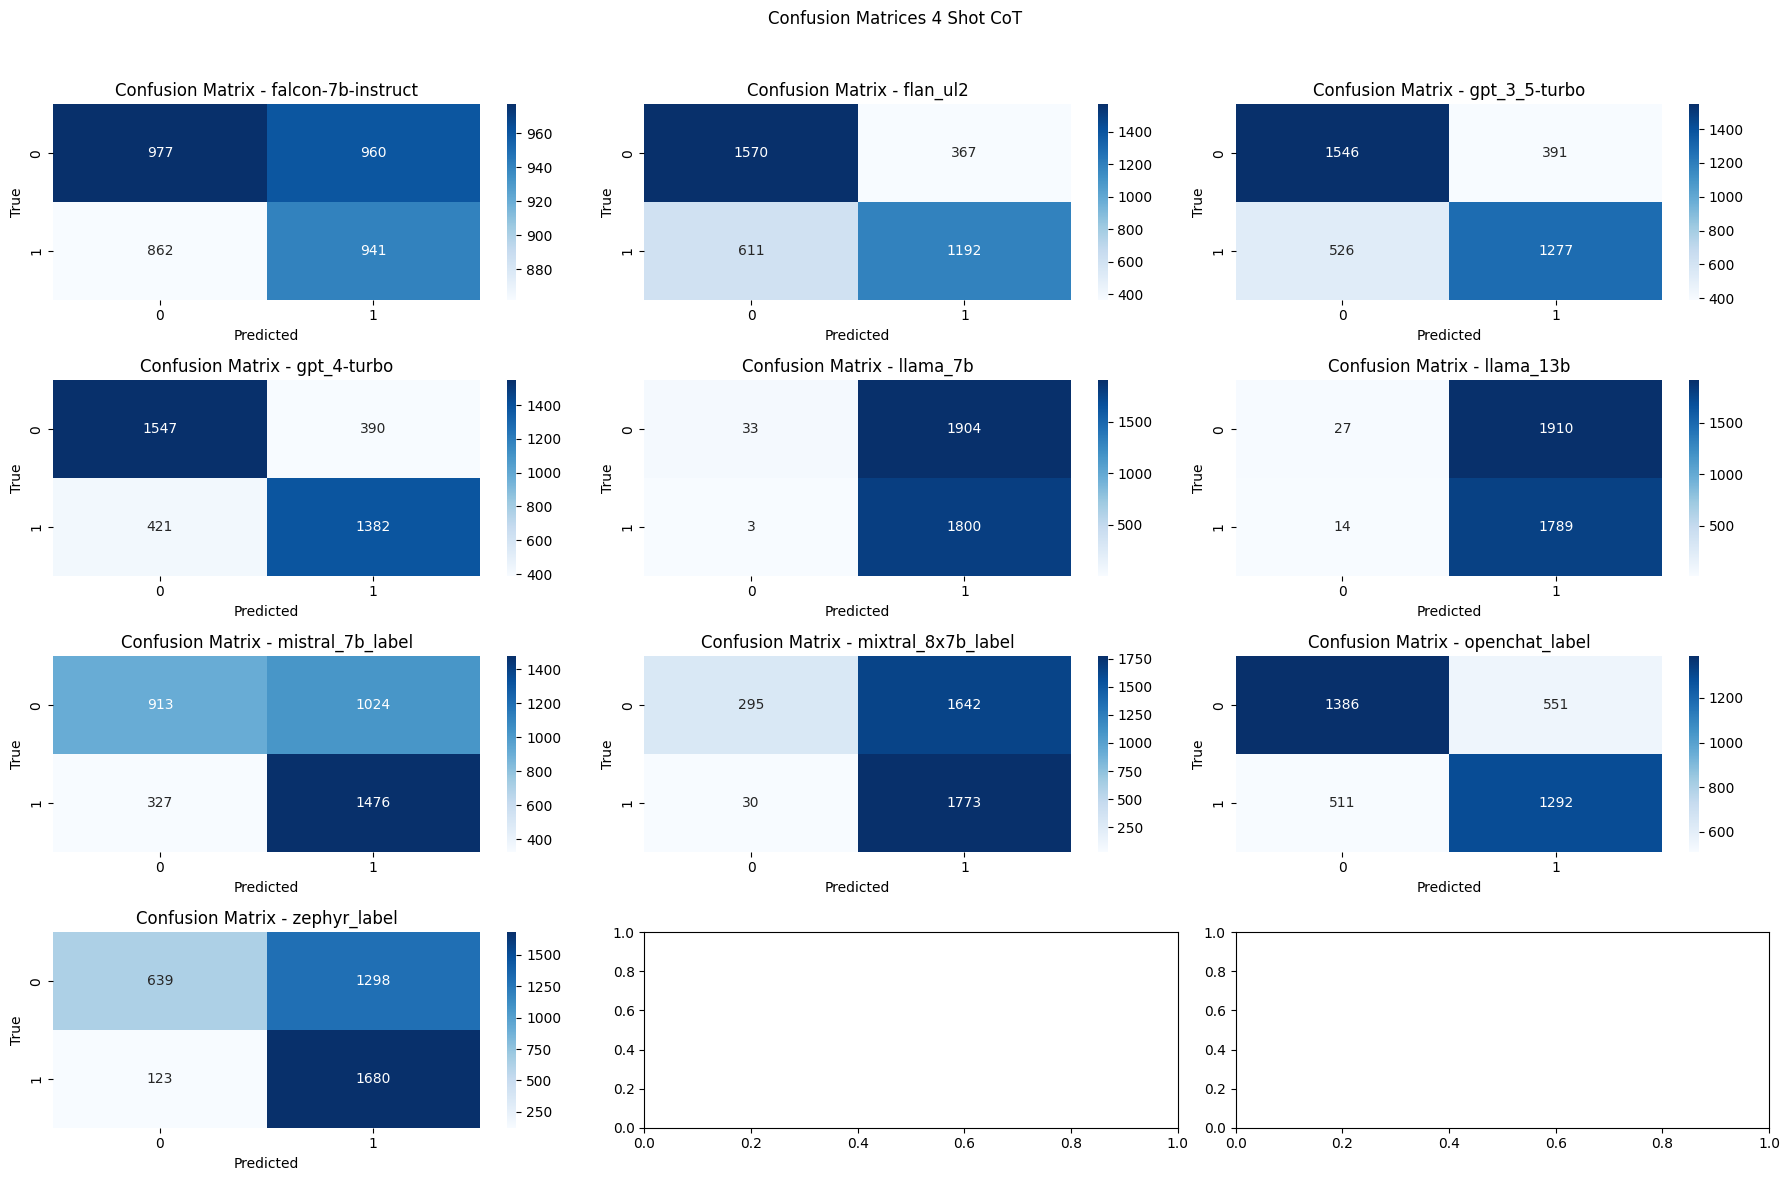

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(ax, df, true_labels_column, predicted_labels_column,
                          title=None
                          ):
    predicted_labels = df[f'{predicted_labels_column}'].astype(int)
    true_labels = df[f'{true_labels_column}'].astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)


    # Display confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True,
                yticklabels=True, ax=ax)

    title = title if title else predicted_labels_column

    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


# Create subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices 4 Shot CoT')


#df_falcon_7b = pd.read_csv(f"./data/falcon-7b-instruct.csv")
#df_flan_ul2 = pd.read_csv(f"./data/flan-ul2.csv")
#df_openai_gpt_3_5_turbo = pd.read_csv('/home/sinix/PycharmProjects/Annomatic_Benchmark/4-shot-CoT/data/gpt-3.5-turbo.csv')
#df_openai_gpt_4_turbo = pd.read_csv(f"./data/gpt-4-1106-preview.csv")
#df_Llama_2_7b = pd.read_csv(f"./data/Llama-2-7b-chat-hf.csv")
#df_Llama_2_13b = pd.read_csv(f"./data/Llama-2-13b-chat-hf.csv")
#df_mistral_7b = pd.read_csv(f"./data/Mistral-7B-Instruct-v0.1.csv")
#df_mixtral_8x7b = pd.read_csv(f"./data/Mixtral-8x7B-Instruct-v0.1.csv")
#df_openchat_3_5 = pd.read_csv(f"./data/openchat_3.5.csv")
#df_zephyr_7b_beta = pd.read_csv(f"./data/zephyr-7b-beta.csv")


# Plot each confusion matrix
plot_confusion_matrix(axes[0, 0], df_merge_all_runs, 'label', 'falcon_7b_label', 'falcon-7b-instruct')
plot_confusion_matrix(axes[0, 1], df_merge_all_runs, 'label', 'flan_ul2_label', 'flan_ul2')
plot_confusion_matrix(axes[0, 2], df_merge_all_runs, 'label', 'gpt_3_5_label', 'gpt_3_5-turbo')
plot_confusion_matrix(axes[1, 0], df_merge_all_runs, 'label', 'gpt_4_label', 'gpt_4-turbo')
plot_confusion_matrix(axes[1, 1], df_merge_all_runs, 'label', 'llama_7b_label', 'llama_7b')
plot_confusion_matrix(axes[1, 2], df_merge_all_runs, 'label', 'llama_13b_label', 'llama_13b')
plot_confusion_matrix(axes[2, 0], df_merge_all_runs, 'label', 'mistral_7b_label', 'mistral_7b_label')
plot_confusion_matrix(axes[2, 1], df_merge_all_runs, 'label', 'mixtral_8x7b_label', 'mixtral_8x7b_label')
plot_confusion_matrix(axes[2, 2], df_merge_all_runs, 'label', 'openchat_label', 'openchat_label')
plot_confusion_matrix(axes[3, 0], df_merge_all_runs, 'label', 'zephyr_label', 'zephyr_label')




plt.tight_layout(
    rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
plt.show()

# Krippendorff Alpha in 4-shot CoT

In [55]:
from krippendorff import alpha
import numpy as np

runs = ['falcon_7b_label', 'flan_ul2_label',
       'gpt_3_5_label', 'gpt_4_label', 'llama_7b_label', 'llama_13b_label',
       'mistral_7b_label', 'mixtral_8x7b_label', 'openchat_label',
       'zephyr_label']


def compute_krippendorff_alpha(dataframe, columns, missing_data='?'):
    """
    Compute Krippendorff's alpha for inter-rater reliability.

    Parameters:
    - dataframe: pd.DataFrame, the DataFrame containing the data.
    - columns: list, the list of column names to calculate alpha for.

    Returns:
    - alpha_value: float, Krippendorff's alpha value.
    """
    # Extract the relevant columns from the DataFrame
    data_subset = dataframe[columns]
    data_subset = data_subset.replace(missing_data, np.nan)

    # Ensure that the data is in a format suitable for krippendorff
    data_list = np.array([data_subset[col].tolist() for col in columns])

    # Calculate Krippendorff's alpha
    alpha_value = alpha(reliability_data=data_list)

    return alpha_value

In [56]:
alpha_value_with_errors = compute_krippendorff_alpha(df_merge_all_runs_with_errors, runs)
alpha_value_without_errors = compute_krippendorff_alpha(df_merge_all_runs, runs)

print(f"Krippendorff's Alpha (all runs with invalid data): {alpha_value_with_errors}")
print(f"Krippendorff's Alpha (all runs without invalid data): {alpha_value_without_errors}")

Krippendorff's Alpha (all runs with invalid data): 0.18160843951997885
Krippendorff's Alpha (all runs without invalid data): 0.18030194822567602


In [57]:
import itertools

def compute_krippendorff_alpha_for_k_runs(df, runs, k=None):
    # Initialize variables to store the best combination and alpha
    if k is None:
        k = len(runs)

    best_combination = None
    best_alpha = 0  # Assuming alpha ranges from 0 to 1

    # Iterate through all possible combinations
    for combination in itertools.combinations(runs, k):

        alpha_value = compute_krippendorff_alpha(df, list(combination))

        # Print alpha for the current combination
        print(f"Combination: {combination}, Alpha: {alpha_value}")

        # Update best combination and alpha if a higher alpha is found
        if alpha_value > best_alpha:
            best_alpha = alpha_value
            best_combination = combination

    # Print the best combination and alpha
    print(f"\nBest Combination: {best_combination}, Best Alpha: {best_alpha}")
    return best_alpha, best_combination

In [58]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.19555889261177806
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.1982135461034198
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: -0.13976935961860582
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: -0.14572131744630945
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.08851171944777614
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: -0.05422686055026671
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.16548950404538532
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.043052029661297175
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.2657567949848245
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: -0.09858655509437919
Combination: ('falcon_7b_label'

(0.6240946308535136, ('flan_ul2_label', 'gpt_3_5_label', 'gpt_4_label'))

In [59]:
compute_krippendorff_alpha_for_k_runs(df_merge_all_runs_with_errors, runs, 3)

Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_3_5_label'), Alpha: 0.19446097015166863
Combination: ('falcon_7b_label', 'flan_ul2_label', 'gpt_4_label'), Alpha: 0.19980541415264563
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_7b_label'), Alpha: -0.1386863799384861
Combination: ('falcon_7b_label', 'flan_ul2_label', 'llama_13b_label'), Alpha: -0.13734947614208237
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mistral_7b_label'), Alpha: 0.08799682386953589
Combination: ('falcon_7b_label', 'flan_ul2_label', 'mixtral_8x7b_label'), Alpha: -0.056304077881102366
Combination: ('falcon_7b_label', 'flan_ul2_label', 'openchat_label'), Alpha: 0.1638864607955839
Combination: ('falcon_7b_label', 'flan_ul2_label', 'zephyr_label'), Alpha: 0.04026100550558487
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'gpt_4_label'), Alpha: 0.2627077658463497
Combination: ('falcon_7b_label', 'gpt_3_5_label', 'llama_7b_label'), Alpha: -0.10134136338195776
Combination: ('falcon_7b_label',

(0.6269059614723216, ('flan_ul2_label', 'gpt_3_5_label', 'gpt_4_label'))

In [60]:
df_merge_all_runs.shape

(3740, 21)

In [61]:
df_merge_all_runs.query("gpt_4_label != mixtral_8x7b_label").shape

(1659, 21)